In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

# offset

keep_frames = 60  # Number of frames to stack
skip_frames = 4
n_stack = 4 #keep_frames // skip_frames

game_env = GameEnv(n_stack, "snes9x.exe", "mario - Snes9x 1.62.3", (200, 150, 550, 500))
camera = game_env.camera

buffer_started


(80, 80)

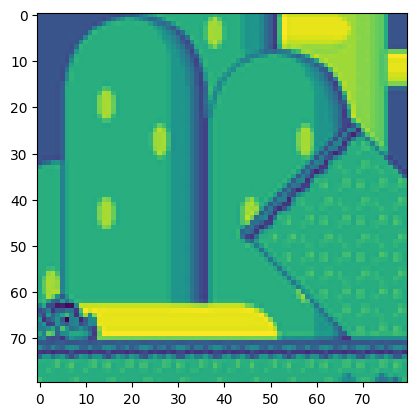

In [5]:
import numpy as np
frame = camera.get_frame()
plt.imshow(frame)
frame.shape

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import gymnasium

# Register the custom environment with Gym
from gymnasium.envs.registration import register

register(
    id='CustomGameEnv-v0',
    entry_point='src.gamenv.gameenv:GameEnv',
    max_episode_steps=None,  # Adjust as needed
)

# Create the environment
# env = gymnasium.make('CustomGameEnv-v0')

# obs = env.reset()
# for _ in range(500):  # Adjust as needed
#     action = env.action_space.sample()  # Replace with your RL agent's action
#     obs, reward, done, truncated, info = env.step(action)
#     env.render()
#     if done or truncated:
#         obs = env.reset()
# env.close()

In [8]:
import gymnasium
import numpy as np
from gymnasium import spaces

env = gymnasium.make('CustomGameEnv-v0')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def norm_obs(obs):
    obs = obs.astype(np.float32) / 255.0  # Scale to [0, 1]
    # Normalize the image
    return (obs - mean) / std

class FrameStackingWrapper(gymnasium.Wrapper):
    def __init__(self, env, keep_frames=4):
        super(FrameStackingWrapper, self).__init__(env)
        self.keep_frames = keep_frames
        self.frames = np.zeros((keep_frames, *env.observation_space.shape), dtype=np.float32)
        
        # self.observation_space = spaces.Box(low=-2.1179, high=2.6400, shape=(n_stack, 180, 180, 3), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, 80, 80), dtype=np.uint8)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # self.frames = np.zeros((self.keep_frames, *self.env.observation_space.shape), dtype=np.float32)
        # for i in range(self.keep_frames):
        #     self.frames[i] = obs.astype(np.float32) / 255.0 # norm_obs(obs)
        # stacked_obs = np.array([self.frames[-1-i] for i in range(keep_frames-1, -1, -1) if i % skip_frames==0])
        # return stacked_obs, info
        return obs[-1], info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        # self.frames[:-1] = self.frames[1:]  # Shift frames
        # self.frames[-1] = obs.astype(np.float32) / 255.0 # norm_obs(obs) # add frame
        # stacked_obs = np.array([self.frames[-1-i] for i in range(keep_frames-1, -1, -1) if i % skip_frames==0])
        # return stacked_obs, reward, done, truncated, info
        return obs[-1], reward, done, truncated, info


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


buffer_started


In [9]:
list([-1-i for i in range(keep_frames-1, -1, -1) if i % skip_frames==0])

[-57, -53, -49, -45, -41, -37, -33, -29, -25, -21, -17, -13, -9, -5, -1]

In [10]:
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack

env = FrameStackingWrapper(env, keep_frames=keep_frames)

In [11]:
obs, _ = env.reset()
obs.shape

(1, 80, 80)

In [12]:
env.observation_space.sample().shape[-3]

1

In [13]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

from stable_baselines3.common.preprocessing import is_image_space

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space:
    :param features_dim: Number of features extracted.
        This corresponds to the number of unit for the last layer.
    :param normalized_image: Whether to assume that the image is already normalized
        or not (this disables dtype and bounds checks): when True, it only checks that
        the space is a Box and has 3 dimensions.
        Otherwise, it checks that it has expected dtype (uint8) and bounds (values in [0, 255]).
    """

    def __init__(
        self,
        observation_space: gymnasium.Space,
        features_dim: int = 512,
        normalized_image: bool = False,
    ) -> None:
        assert isinstance(observation_space, spaces.Box), (
            "NatureCNN must be used with a gym.spaces.Box ",
            f"observation space, not {observation_space}",
        )
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        assert is_image_space(observation_space, check_channels=False, normalized_image=normalized_image), (
            "You should use NatureCNN "
            f"only with images not with {observation_space}\n"
            "(you are probably using `CnnPolicy` instead of `MlpPolicy` or `MultiInputPolicy`)\n"
            "If you are using a custom environment,\n"
            "please check it using our env checker:\n"
            "https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html.\n"
            "If you are using `VecNormalize` or already normalized channel-first images "
            "you should pass `normalize_images=False`: \n"
            "https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html"
        )
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))


policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    activation_fn=th.nn.ReLU,
)

In [14]:
from stable_baselines3.common.callbacks import BaseCallback
import pandas as pd

class BeforeTrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(BeforeTrainingCallback, self).__init__(verbose)
        self.steps_diff_times = []

    def _on_step(self) -> bool:
        # This method needs to be implemented but can remain empty if not needed
        curr_time = time.time()
        self.steps_diff_times.append(curr_time - self.steps_last_diff_time)
        self.steps_last_diff_time = curr_time
        return True

    def _on_rollout_end(self) -> None:
        # This method is called before the training process starts after n_steps
        env.toggle_pause()
        print("Rollout has ended, training is about to start.")
        print(
            pd.DataFrame.from_dict({
                "step_time": self.steps_diff_times
            }).describe()
        )
        env.camera.stop_buffer()
    
    def _on_rollout_start(self) -> None:
        print("Training has ended!")
        self.steps_last_diff_time = time.time()
        env.toggle_pause()

# Create the callback
callback = BeforeTrainingCallback()

In [15]:

from stable_baselines3.common.vec_env import VecNormalize
normed_env = VecNormalize(env, norm_reward=True)

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_attr to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_attr` for environment variables or `env.get_wrapper_attr('get_attr')` that will search the reminding wrappers.
  logger.warn(
c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The 

In [16]:
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy, RecurrentActorCriticCnnPolicy
from sb3_contrib import RecurrentPPO
model = RecurrentPPO(RecurrentActorCriticCnnPolicy, env, verbose=2,
    learning_rate=1e-5,
    n_steps=2048,
    batch_size=128, 
    clip_range=0.2, 
    max_grad_norm=0.5,
    ent_coef=0.001,
    n_epochs=30,
    tensorboard_log="./ppo_super_mario_tensorboard/",
    #policy_kwargs=policy_kwargs,
)
model.policy

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RecurrentActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=2304, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=2304, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
  

In [17]:
# model.load("model.zip")

In [20]:
env.reset()
model.learn(total_timesteps=5_000_000, callback=callback)

buffer_started
Logging to ./ppo_super_mario_tensorboard/RecurrentPPO_30
Training has ended!
Rollout has ended, training is about to start.
          step_time
count  36649.000000
mean       0.080097
std        0.075991
min        0.052292
25%        0.059020
50%        0.069033
75%        0.075431
max        0.999544
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 56.8     |
|    ep_rew_mean     | 3.25     |
| time/              |          |
|    fps             | 13       |
|    iterations      | 1        |
|    time_elapsed    | 148      |
|    total_timesteps | 2048     |
---------------------------------


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
Rollout has ended, training is about to start.
          step_time
count  38697.000000
mean       0.079684
std        0.075817
min        0.052278
25%        0.057992
50%        0.069001
75%        0.075022
max        0.999544
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 3.04          |
| time/                   |               |
|    fps                  | 12            |
|    iterations           | 2             |
|    time_elapsed         | 330           |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00042820312 |
|    clip_fraction        | 0.0078        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0542       |
|    explained_variance   | 0.976         |
|    learning_rate        | 1e-05         |
|    loss                 | -0.00216      |
|    n_upd

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
Rollout has ended, training is about to start.
          step_time
count  40745.000000
mean       0.079310
std        0.075715
min        0.052278
25%        0.057216
50%        0.068947
75%        0.074346
max        0.999544
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 3.07          |
| time/                   |               |
|    fps                  | 12            |
|    iterations           | 3             |
|    time_elapsed         | 511           |
|    total_timesteps      | 6144          |
| train/                  |               |
|    approx_kl            | 0.00024860198 |
|    clip_fraction        | 0.00462       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0454       |
|    explained_variance   | 0.999         |
|    learning_rate        | 1e-05         |
|    loss                 | 0.00264       |
|    n_upd

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
Rollout has ended, training is about to start.
          step_time
count  42793.000000
mean       0.078958
std        0.075557
min        0.052218
25%        0.056973
50%        0.068801
75%        0.073017
max        0.999544
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 2.95         |
| time/                   |              |
|    fps                  | 11           |
|    iterations           | 4            |
|    time_elapsed         | 692          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0002954253 |
|    clip_fraction        | 0.00643      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0374      |
|    explained_variance   | 0.988        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.00303      |
|    n_updates            |

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
Rollout has ended, training is about to start.
          step_time
count  44841.000000
mean       0.078671
std        0.075485
min        0.052197
25%        0.056593
50%        0.068641
75%        0.071738
max        0.999544
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 2.97         |
| time/                   |              |
|    fps                  | 11           |
|    iterations           | 5            |
|    time_elapsed         | 873          |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0010351329 |
|    clip_fraction        | 0.000814     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0419      |
|    explained_variance   | 0.999        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.00244      |
|    n_updates            |

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
Rollout has ended, training is about to start.
          step_time
count  46889.000000
mean       0.078406
std        0.075367
min        0.052197
25%        0.056491
50%        0.068517
75%        0.071014
max        0.999544
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.1        |
|    ep_rew_mean          | 3.12        |
| time/                   |             |
|    fps                  | 11          |
|    iterations           | 6           |
|    time_elapsed         | 1054        |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.027103236 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0835     |
|    explained_variance   | 0.987       |
|    learning_rate        | 1e-05       |
|    loss                 | -0.00961    |
|    n_updates            | 630         |
| 

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
Rollout has ended, training is about to start.
          step_time
count  48937.000000
mean       0.078132
std        0.075177
min        0.052197
25%        0.056320
50%        0.068368
75%        0.070654
max        0.999544
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.7         |
|    ep_rew_mean          | 3.3          |
| time/                   |              |
|    fps                  | 11           |
|    iterations           | 7            |
|    time_elapsed         | 1236         |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0006507237 |
|    clip_fraction        | 0.00993      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.134       |
|    explained_variance   | 0.888        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.169        |
|    n_updates            |

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.camera to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.camera` for environment variables or `env.get_wrapper_attr('camera')` that will search the reminding wrappers.
  logger.warn(


Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


buffer_started
mario - Snes9x 1.62.3 cannot be minimized.


StopAsyncIteration: Frame buffer is not running

In [19]:
while True:
    obs, _ = env.reset()
    done = False
    while not done:
        action, _state = model.predict(obs, deterministic=False)
        next_obs, reward, done, truncated, info = env.step(action)
        obs = next_obs

buffer_started
mario - Snes9x 1.62.3 cannot be minimized.


StopAsyncIteration: Frame buffer is not running

In [ ]:
# from ray.tune.search.optuna import OptunaSearch

# from ray.tune.schedulers import ASHAScheduler


# config = {
#     "lr": tune.loguniform(1e-8, 1e-0),
#     "clip_range": tune.uniform(0.01,0.5),
#     "n_steps": tune.choice([256, 512, 1028, 2056, 4096]),
#     "batch_size": tune.choice([32, 64, 128]),
#     "max_grad_norm": tune.uniform(0.1, 1),
#     "ent_coef": tune.loguniform(1e-5, 1e-0),
#     "vf_coef": tune.uniform(0.1, 1),
# }

# metric = "avg_reward"
# mode = "max"

# optuna_search = OptunaSearch(
#     metric=metric,
#     mode=mode,
#     # points_to_evaluate = curr_best_params,
# )

# asas_scheduler = ASHAScheduler(
#     time_attr='training_iteration',
#     metric=metric,
#     mode=mode,
#     max_t=30,
#     grace_period=1,
#     reduction_factor=3,
#     brackets=2
# )

# trainable_with_resources = tune.with_resources(train_agent, {"cpu": 12, "gpu": 1})

# tuner = tune.Tuner(
#     trainable_with_resources,
#     tune_config=tune.TuneConfig(
#         num_samples=5,
#         search_alg=optuna_search,
#         scheduler=asas_scheduler
#     ),
#     param_space=config,
# )
# results = tuner.fit()

In [ ]:

# Retrieve the environment
# env = model.get_env()
# Train the agent
# model.learn(total_timesteps=100000)
# Save the agent

model.save("model")
# the policy_kwargs are automatically loaded

In [ ]:
# import numpy as np

# from sb3_contrib import RecurrentPPO
# from stable_baselines3.common.evaluation import evaluate_policy

# from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# model = RecurrentPPO("MlpLstmPolicy", "CartPole-v1", verbose=1)
# model.learn(5000)

# vec_env = model.get_env()
# vec_env.reset()
# vec_env.step([vec_env.action_space.sample()])
# vec_env.step([vec_env.action_space.sample()])

In [ ]:

# mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=20, warn=False)
# print(mean_reward)

# model.save("ppo_recurrent")
# del model # remove to demonstrate saving and loading

# model = RecurrentPPO.load("ppo_recurrent")

# obs = vec_env.reset()
# # cell and hidden state of the LSTM
# lstm_states = None
# num_envs = 1
# # Episode start signals are used to reset the lstm states
# episode_starts = np.ones((num_envs,), dtype=bool)
# while True:
#     action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
#     obs, rewards, dones, info = vec_env.step(action)
#     episode_starts = dones
#     vec_env.render("human")